<a href="https://colab.research.google.com/github/Jarnoesse/IA-AGN-with-ML/blob/main/classifier_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following part is the data analisys/dimensional reduction from mr. Pedro Ferreira's notebook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, plot_confusion_matrix, classification_report, explained_variance_score

from pandas.plotting import scatter_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

import missingno as msno

plt.style.use('seaborn')


import os.path

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Adding colors**: We do this because this gives us the slope of a magnitude plot, so it's a really important aspect of this data and gives us a lot of useful information. Having it done without the non-visible colors before, we see a clear improvement on the dimensionality reduction plots when we add the IR and near-IR colors (W1-W2,J-KS,KS-W1)! [Pedro Ferreira]

In [ ]:
table_des_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_DES_specZ_milliquas_basicFeatures.csv'
table_des_cat = Table.read(table_des_catalogue_URL)

des_df = table_des_cat.to_pandas()

table_ps_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_PS_specZ_milliquas_basicFeatures.csv'
table_ps_cat = Table.read(table_ps_catalogue_URL)

ps_df = table_ps_cat.to_pandas()

table_sm_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv'
table_sm_cat = Table.read(table_sm_catalogue_URL)

sm_df = table_sm_cat.to_pandas()

In [ ]:
des_df['W1-W2'] = des_df['W1MAG']-des_df['W2MAG']
des_df['J-KS'] = des_df['J_VISTA']-des_df['KS_VISTA']
des_df['KS-W1'] = des_df['KS_VISTA']-des_df['W1MAG']
des_df['G-R'] = des_df['MAG_G']-des_df['MAG_R']
des_df['R-Z'] = des_df['MAG_R']-des_df['MAG_Z']
des_df['Z-J'] = des_df['MAG_Z']-des_df['J_VISTA']
des_df['G-RadioR'] = des_df['MAG_G']-des_df['flux_int']
des_df['W2-RadioR'] = des_df['W2MAG']-des_df['flux_int']

ps_df['W1-W2'] = ps_df['W1MAG']-ps_df['W2MAG']
ps_df['J-KS'] = ps_df['J_VISTA']-ps_df['KS_VISTA']
ps_df['KS-W1'] = ps_df['KS_VISTA']-ps_df['W1MAG']
ps_df['G-R'] = ps_df['MAG_G']-ps_df['MAG_R']
ps_df['R-Z'] = ps_df['MAG_R']-ps_df['MAG_Z']
ps_df['Z-J'] = ps_df['MAG_Z']-ps_df['J_VISTA']
ps_df['G-RadioR'] = ps_df['MAG_G']-ps_df['flux_int']
ps_df['W2-RadioR'] = ps_df['W2MAG']-ps_df['flux_int']

sm_df['W1-W2'] = sm_df['W1MAG']-sm_df['W2MAG']
sm_df['J-KS'] = sm_df['J_VISTA']-sm_df['KS_VISTA']
sm_df['KS-W1'] = sm_df['KS_VISTA']-sm_df['W1MAG']
sm_df['U-G'] = sm_df['MAG_U']-sm_df['MAG_G']
sm_df['G-R'] = sm_df['MAG_G']-sm_df['MAG_R']
sm_df['R-Z'] = sm_df['MAG_R']-sm_df['MAG_Z']
sm_df['Z-J'] = sm_df['MAG_Z']-sm_df['J_VISTA']
sm_df['G-RadioR'] = sm_df['MAG_G']-sm_df['flux_int']
sm_df['W2-RadioR'] = sm_df['W2MAG']-sm_df['flux_int']

**Working with the data catalogues**: from the above dataframe, we remove the features that won't contribute to the analysis, like the ones that just identify the objects. We also remove the class (star, agn, galaxy) and the redshift because we want to check afterwards if there is clusters on the reduced data plots that relate to each object's redshift and class.

In [ ]:
des_sample = des_df.drop(['n_components','col0','catalogue_id','quality_level','SOURCEID_VISTA'], axis = 1)
des_sample = des_sample.dropna()  #sem os unclassified
desarray = des_sample.drop(['z_spec','spec_class'], axis=1).to_numpy()

ps_sample = ps_df.drop(['n_components','col0','catalogue_id','quality_level','SOURCEID_VISTA'], axis = 1)
ps_sample = ps_sample.dropna()  #sem os unclassified
psarray = ps_sample.drop(['z_spec','spec_class'], axis=1).to_numpy()

sm_sample = sm_df.drop(['n_components','col0','catalogue_id','quality_level','SOURCEID_VISTA'], axis = 1)
sm_sample = sm_sample.dropna()  #sem os unclassified
smarray = sm_sample.drop(['z_spec','spec_class'], axis=1).to_numpy()

So this is one of the dataframes on which we will do dimensionality reduction:

In [ ]:
ps_sample

,flux_int,flux_peak,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,14.271548,14.272466,14.449,14.211,14.706843,14.757310,0.000171,15.9414,15.4132,15.2604,15.0925,0.082,1,0.238000,-0.050467,0.308310,0.5282,0.3207,0.385657,1.669852,-0.060549
1,15.087712,15.005931,15.582,15.717,15.234133,14.885287,0.000171,16.1638,15.5859,15.3284,15.1686,0.062,1,-0.135000,0.348846,-0.696713,0.5779,0.4173,-0.065533,1.076088,0.629288
2,8.276081,8.479472,14.661,14.276,16.120893,15.419022,0.052478,16.6373,16.5356,16.6504,16.1415,0.391,1,0.385000,0.701871,0.758022,0.1017,0.3941,0.020607,8.361219,5.999919
3,12.600692,12.604439,19.226,19.309,19.790708,19.173853,0.499230,19.9939,20.2113,20.0435,19.7645,2.367,1,-0.083000,0.616855,-0.052147,-0.2174,0.4468,-0.026208,7.393208,6.708308
4,15.417818,15.128676,17.898,18.291,17.633600,17.159678,0.000171,19.7773,18.7711,18.3317,17.9279,0.271,1,-0.392999,0.473922,-0.738322,1.0062,0.8432,0.294300,4.359482,2.873182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71505,13.008310,13.038626,18.439,17.840,20.034221,18.905024,0.000010,21.2537,21.5828,20.9368,20.0989,0.195,1,0.598999,1.129197,0.466024,-0.3291,1.4839,0.064679,8.245390,4.831690
71506,13.113121,13.132223,16.787,16.525,17.724560,17.162191,0.999981,20.4939,19.5336,18.6965,18.3080,0.564,1,0.262000,0.562369,0.375191,0.9603,1.2256,0.583440,7.380779,3.411879
71507,11.578844,12.868261,17.047,16.629,18.276413,17.892172,0.000171,19.0971,19.1318,18.7885,18.4751,0.586,1,0.418000,0.384241,0.845172,-0.0347,0.6567,0.198687,7.518256,5.050156
71508,13.890164,13.856373,18.082,17.727,18.505855,18.459696,0.999657,19.0425,18.8057,18.9779,18.8010,0.963,1,0.355001,0.046159,0.377696,0.2368,0.0047,0.295145,5.152336,3.836835


In [ ]:
ps_sample["spec_class"].value_counts()

2    10629
1     2751
0       84
Name: spec_class, dtype: Int64

Dropping unimportant (or higly correlatred labels)

In [ ]:
des_df = des_df.drop(['col0','catalogue_id','flux_peak','quality_level','SOURCEID_VISTA','W1MAG','J_VISTA','KS_VISTA','MAG_G','MAG_R','MAG_I','MAG_Z'], axis = 1)
ps_df = ps_df.drop(['col0','catalogue_id','flux_peak','quality_level','SOURCEID_VISTA','W2MAG','J_VISTA','KS_VISTA','MAG_G','MAG_R','MAG_I','MAG_Z'], axis = 1)
sm_df = sm_df.drop(['col0','catalogue_id','flux_peak','quality_level','SOURCEID_VISTA','W1MAG','J_VISTA','KS_VISTA','MAG_U','MAG_G','MAG_R','MAG_I','MAG_Z'], axis = 1)

ML model with keras

In [ ]:
from numpy import unique
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix

In [ ]:
ps_sample

,flux_int,flux_peak,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,14.271548,14.272466,14.449,14.211,14.706843,14.757310,0.000171,15.9414,15.4132,15.2604,15.0925,0.082,1,0.238000,-0.050467,0.308310,0.5282,0.3207,0.385657,1.669852,-0.060549
1,15.087712,15.005931,15.582,15.717,15.234133,14.885287,0.000171,16.1638,15.5859,15.3284,15.1686,0.062,1,-0.135000,0.348846,-0.696713,0.5779,0.4173,-0.065533,1.076088,0.629288
2,8.276081,8.479472,14.661,14.276,16.120893,15.419022,0.052478,16.6373,16.5356,16.6504,16.1415,0.391,1,0.385000,0.701871,0.758022,0.1017,0.3941,0.020607,8.361219,5.999919
3,12.600692,12.604439,19.226,19.309,19.790708,19.173853,0.499230,19.9939,20.2113,20.0435,19.7645,2.367,1,-0.083000,0.616855,-0.052147,-0.2174,0.4468,-0.026208,7.393208,6.708308
4,15.417818,15.128676,17.898,18.291,17.633600,17.159678,0.000171,19.7773,18.7711,18.3317,17.9279,0.271,1,-0.392999,0.473922,-0.738322,1.0062,0.8432,0.294300,4.359482,2.873182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71505,13.008310,13.038626,18.439,17.840,20.034221,18.905024,0.000010,21.2537,21.5828,20.9368,20.0989,0.195,1,0.598999,1.129197,0.466024,-0.3291,1.4839,0.064679,8.245390,4.831690
71506,13.113121,13.132223,16.787,16.525,17.724560,17.162191,0.999981,20.4939,19.5336,18.6965,18.3080,0.564,1,0.262000,0.562369,0.375191,0.9603,1.2256,0.583440,7.380779,3.411879
71507,11.578844,12.868261,17.047,16.629,18.276413,17.892172,0.000171,19.0971,19.1318,18.7885,18.4751,0.586,1,0.418000,0.384241,0.845172,-0.0347,0.6567,0.198687,7.518256,5.050156
71508,13.890164,13.856373,18.082,17.727,18.505855,18.459696,0.999657,19.0425,18.8057,18.9779,18.8010,0.963,1,0.355001,0.046159,0.377696,0.2368,0.0047,0.295145,5.152336,3.836835


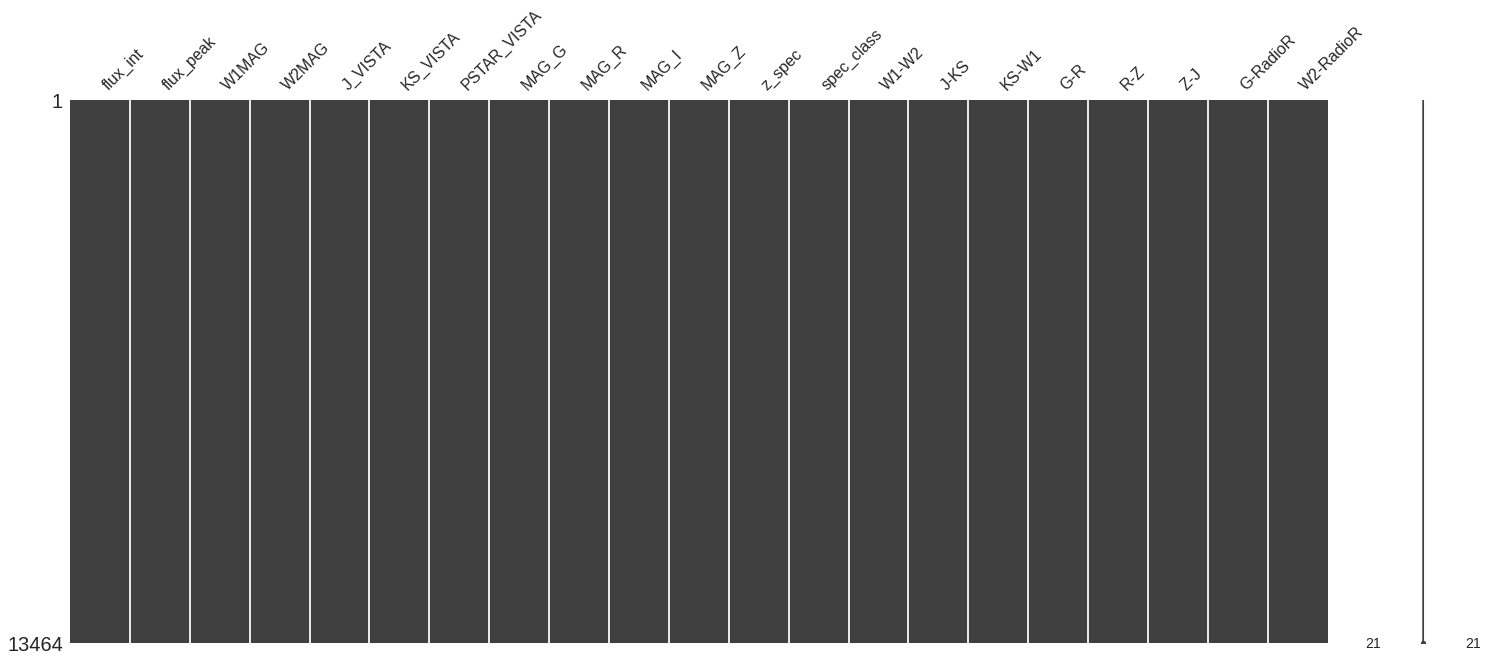

In [ ]:
msno.matrix(ps_sample)

In [ ]:
ps_sample

,flux_int,flux_peak,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,14.271548,14.272466,14.449,14.211,14.706843,14.757310,0.000171,15.9414,15.4132,15.2604,15.0925,0.082,1,0.238000,-0.050467,0.308310,0.5282,0.3207,0.385657,1.669852,-0.060549
1,15.087712,15.005931,15.582,15.717,15.234133,14.885287,0.000171,16.1638,15.5859,15.3284,15.1686,0.062,1,-0.135000,0.348846,-0.696713,0.5779,0.4173,-0.065533,1.076088,0.629288
2,8.276081,8.479472,14.661,14.276,16.120893,15.419022,0.052478,16.6373,16.5356,16.6504,16.1415,0.391,1,0.385000,0.701871,0.758022,0.1017,0.3941,0.020607,8.361219,5.999919
3,12.600692,12.604439,19.226,19.309,19.790708,19.173853,0.499230,19.9939,20.2113,20.0435,19.7645,2.367,1,-0.083000,0.616855,-0.052147,-0.2174,0.4468,-0.026208,7.393208,6.708308
4,15.417818,15.128676,17.898,18.291,17.633600,17.159678,0.000171,19.7773,18.7711,18.3317,17.9279,0.271,1,-0.392999,0.473922,-0.738322,1.0062,0.8432,0.294300,4.359482,2.873182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71505,13.008310,13.038626,18.439,17.840,20.034221,18.905024,0.000010,21.2537,21.5828,20.9368,20.0989,0.195,1,0.598999,1.129197,0.466024,-0.3291,1.4839,0.064679,8.245390,4.831690
71506,13.113121,13.132223,16.787,16.525,17.724560,17.162191,0.999981,20.4939,19.5336,18.6965,18.3080,0.564,1,0.262000,0.562369,0.375191,0.9603,1.2256,0.583440,7.380779,3.411879
71507,11.578844,12.868261,17.047,16.629,18.276413,17.892172,0.000171,19.0971,19.1318,18.7885,18.4751,0.586,1,0.418000,0.384241,0.845172,-0.0347,0.6567,0.198687,7.518256,5.050156
71508,13.890164,13.856373,18.082,17.727,18.505855,18.459696,0.999657,19.0425,18.8057,18.9779,18.8010,0.963,1,0.355001,0.046159,0.377696,0.2368,0.0047,0.295145,5.152336,3.836835


In [ ]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = ps_sample[attributes].values

checking the dataset

In [ ]:
dataset

array([[14.27154833, 14.27246598, 14.449     , ...,  0.385657  ,
         1.66985167, -0.06054859],
       [15.08771213, 15.00593128, 15.58200037, ..., -0.065533  ,
         1.07608787,  0.62928813],
       [ 8.27608086,  8.47947176, 14.66099989, ...,  0.020607  ,
         8.36121914,  5.99991942],
       ...,
       [11.57884394, 12.86826077, 17.04699957, ...,  0.198687  ,
         7.51825606,  5.05015603],
       [13.89016448, 13.85637318, 18.08200037, ...,  0.295145  ,
         5.15233552,  3.83683505],
       [15.16600638, 15.04480463, 17.22600043, ...,  0.282338  ,
         4.17409362,  2.26399323]])

Creating the y arrays for classification and the regression, turning the y regression and the datasets into floats for better handling by Keras

In [ ]:
y_class = ps_sample["spec_class"].values
y =ps_sample["z_spec"].values 
n_class = len(unique(y_class))
dataset, y, y_class = dataset.astype('float'), y.astype('float'),y_class.astype("int")

Calculating the feature number we want to pass to the Keras model

In [ ]:
n_features = dataset.shape[1]

splitting train and test sets

In [ ]:
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(dataset, y, y_class, test_size=0.33, random_state=1)

compiling the keras model

In [ ]:
visible = Input(shape=(n_features,))
hidden1 = Dense(20, activation='relu', kernel_initializer='he_normal')(visible)
hidden3 = Dense(50, activation = "relu", kernel_initializer="he_normal")(hidden1)
dropout1 = Dropout(0.2)(hidden3)
hidden2 = Dense(10, activation='relu', kernel_initializer='he_normal')(dropout1)


In [ ]:
out_reg = Dense(1, activation='linear')(hidden2)

In [ ]:
out_clas = Dense(n_class, activation='softmax')(hidden2)

In [ ]:
model = Model(inputs=visible, outputs=[out_reg, out_clas])

In [ ]:
model.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

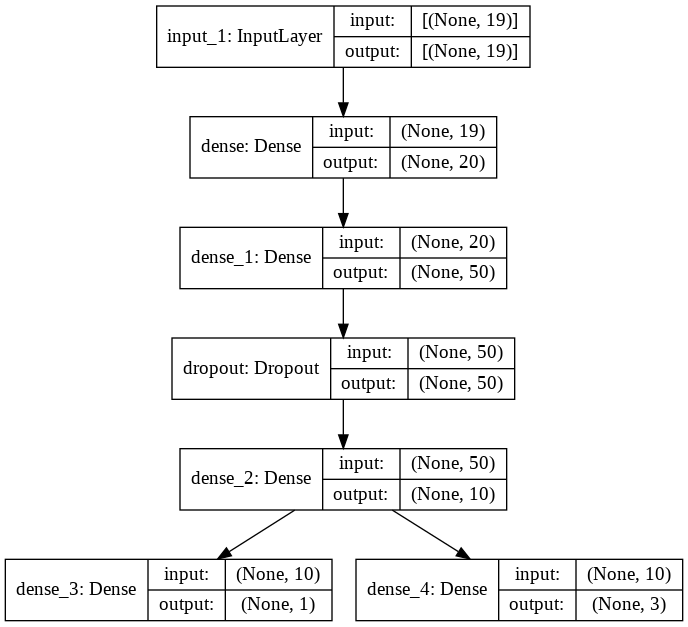

In [ ]:
# plot graph of model
plot_model(model, to_file='model.png', show_shapes=True)

fitting the model

In [ ]:
model.fit(X_train, [y_train,y_train_class], epochs=300, batch_size=32, verbose=2)

Epoch 1/300
282/282 - 1s - loss: 14.5156 - dense_3_loss: 9.5863 - dense_4_loss: 4.9293
Epoch 2/300
282/282 - 0s - loss: 1.2551 - dense_3_loss: 0.4624 - dense_4_loss: 0.7927
Epoch 3/300
282/282 - 0s - loss: 0.9074 - dense_3_loss: 0.3369 - dense_4_loss: 0.5704
Epoch 4/300
282/282 - 0s - loss: 0.8796 - dense_3_loss: 0.3179 - dense_4_loss: 0.5617
Epoch 5/300
282/282 - 0s - loss: 0.8686 - dense_3_loss: 0.3061 - dense_4_loss: 0.5625
Epoch 6/300
282/282 - 0s - loss: 0.8585 - dense_3_loss: 0.2951 - dense_4_loss: 0.5634
Epoch 7/300
282/282 - 0s - loss: 0.8475 - dense_3_loss: 0.2838 - dense_4_loss: 0.5637
Epoch 8/300
282/282 - 0s - loss: 0.8365 - dense_3_loss: 0.2664 - dense_4_loss: 0.5702
Epoch 9/300
282/282 - 0s - loss: 0.8090 - dense_3_loss: 0.2400 - dense_4_loss: 0.5690
Epoch 10/300
282/282 - 0s - loss: 0.7660 - dense_3_loss: 0.2095 - dense_4_loss: 0.5564
Epoch 11/300
282/282 - 0s - loss: 0.7140 - dense_3_loss: 0.1879 - dense_4_loss: 0.5261
Epoch 12/300
282/282 - 0s - loss: 0.6438 - dense_3_

In [ ]:
yhat1, yhat2 = model.predict(X_test)

In [ ]:
yhat1

array([[7.76235163e-02],
       [8.02017748e-04],
       [8.04223061e-01],
       ...,
       [1.20064445e-01],
       [5.90191446e-02],
       [9.55880433e-02]], dtype=float32)

In [ ]:
yhat2

array([[8.1933220e-05, 8.9823827e-03, 9.9093562e-01],
       [8.6393993e-06, 1.0016968e-02, 9.8997432e-01],
       [2.4962409e-03, 9.1785699e-01, 7.9646789e-02],
       ...,
       [2.6906736e-02, 1.5872030e-01, 8.1437296e-01],
       [2.5494616e-03, 5.2201623e-01, 4.7543433e-01],
       [1.6836102e-04, 2.6138555e-02, 9.7369301e-01]], dtype=float32)

In [ ]:
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.113


In [ ]:
yhat2 = argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

Accuracy: 0.923


In [ ]:
confusion_matrix(y_test_class,yhat2)

array([[  16,    0,    1],
       [   0,  634,  263],
       [   5,   71, 3454]])

Other Try

In [ ]:
model = Model(inputs=visible, outputs = out_clas)

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_class),
                                                 y_train_class)

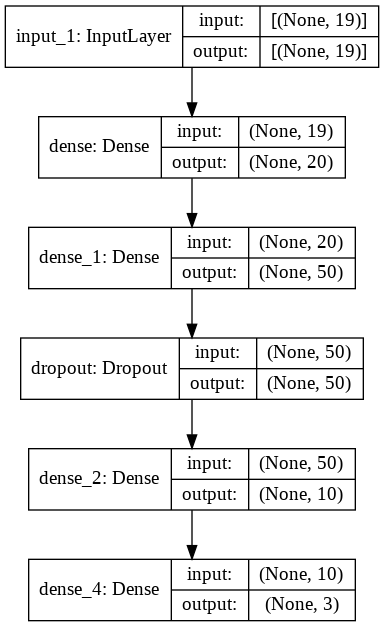

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

In [ ]:
class_weights

array([44.87562189,  1.62171881,  0.42353383])

In [ ]:
class_weights = {
    0: 44.8756219,
    1: 1.62171881,
    2: 0.42353383,
    }

In [ ]:
model.fit(X_train, y_train_class, epochs = 300, batch_size=32, verbose=2, class_weight=class_weights)

Epoch 1/300
282/282 - 1s - loss: 1.1111
Epoch 2/300
282/282 - 0s - loss: 1.1111
Epoch 3/300
282/282 - 0s - loss: 1.1111
Epoch 4/300
282/282 - 0s - loss: 1.1111
Epoch 5/300
282/282 - 0s - loss: 1.1111
Epoch 6/300
282/282 - 0s - loss: 1.1111
Epoch 7/300
282/282 - 0s - loss: 1.1111
Epoch 8/300
282/282 - 0s - loss: 1.1111
Epoch 9/300
282/282 - 0s - loss: 1.1111
Epoch 10/300
282/282 - 0s - loss: 1.1111
Epoch 11/300
282/282 - 0s - loss: 1.1111
Epoch 12/300
282/282 - 0s - loss: 1.1111
Epoch 13/300
282/282 - 0s - loss: 1.1111
Epoch 14/300
282/282 - 0s - loss: 1.1111
Epoch 15/300
282/282 - 0s - loss: 1.1111
Epoch 16/300
282/282 - 0s - loss: 1.1111
Epoch 17/300
282/282 - 0s - loss: 1.1111
Epoch 18/300
282/282 - 0s - loss: 1.1111
Epoch 19/300
282/282 - 0s - loss: 1.1111
Epoch 20/300
282/282 - 0s - loss: 1.1111
Epoch 21/300
282/282 - 0s - loss: 1.1111
Epoch 22/300
282/282 - 0s - loss: 1.1111
Epoch 23/300
282/282 - 0s - loss: 1.1111
Epoch 24/300
282/282 - 0s - loss: 1.1111
Epoch 25/300
282/282 - 0s

In [ ]:
yhat2 = model.predict(X_test)

In [ ]:
yhat2

array([[0.33333567, 0.3333313 , 0.33333308],
       [0.33333567, 0.3333313 , 0.33333308],
       [0.33333567, 0.3333313 , 0.33333308],
       ...,
       [0.33333567, 0.3333313 , 0.33333308],
       [0.33333567, 0.3333313 , 0.33333308],
       [0.33333567, 0.3333313 , 0.33333308]], dtype=float32)

In [ ]:
yhat2 = argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

Accuracy: 0.004


In [ ]:
confusion_matrix(y_test_class,yhat2)

array([[  17,    0,    0],
       [ 897,    0,    0],
       [3530,    0,    0]])